# Tree Based Modelling

## $\textbf{1. Imports}$

$\textbf{Import Libraries}$

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

$\textbf{Import Data}$

In [2]:
def load_dataframes(imputed_file_path, daily_file_path):
    imputed_df = pd.read_csv(imputed_file_path)
    daily_df = pd.read_csv(daily_file_path)
    return imputed_df, daily_df

In [3]:
imputed_file_path = '..\\data\\interim\\imputed_data.csv'
daily_file_path = '..\\data\\interim\\daily_averaged_data.csv'
_, daily_df = load_dataframes(imputed_file_path, daily_file_path)

In [4]:
daily_df.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,0,2020-01-10,31.014205,59.032513,596.025884,221.333333,138.740530,247.036301,277.455808,2.108586,0.0
1,0,2020-01-11,31.035732,58.875316,588.204167,233.916667,135.968434,247.013889,277.169003,2.102694,0.0
2,0,2020-01-12,31.013889,58.989583,581.595328,231.826389,127.770833,247.000000,277.060922,2.020202,0.0
3,0,2020-01-13,31.008102,58.996528,575.665509,224.361111,131.902778,247.000000,277.145833,2.027778,0.0
4,0,2020-01-14,31.035038,59.003472,572.395202,224.000000,118.000000,247.000000,277.340593,1.968434,0.0


## $\textbf{Functions}$

**Plotting**

In [5]:
def plot_roc_curve_and_confusion_matrix(y_true, y_pred):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title('Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('1-Specificity')
    axs[1].set_ylabel('Sensitivity')
    axs[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    
    return cm

def calculate_metrics_from_confusion_matrix(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Score': [accuracy, precision, recall, f1]
    })

    return metrics_df

**DataPipeline**

In [6]:
def select_features_(df, selected_columns):
    selected_data = df[selected_columns]
    return selected_data

def train_test_split_(df, test_well_ids):
    train_data = df[~df['NodeID'].isin(test_well_ids)]
    test_data = df[df['NodeID'].isin(test_well_ids)]
    return train_data, test_data

## $\textbf{2. Creating Training Data}$

In [7]:
num_wells_in_training = 11

train_data, test_data =  train_test_split_(daily_df, test_well_ids = [7])

In [8]:
test_data.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
614,7,2020-03-21,25.115088,45.860739,998.333112,175.533460,103.704861,269.716225,291.604482,5.614899,0.0
615,7,2020-03-22,27.703630,49.533984,1001.313826,228.688131,98.306503,269.306503,292.509470,5.699179,0.0
616,7,2020-03-23,27.490183,49.201878,1015.948801,202.781566,96.322917,270.763258,293.320707,5.913826,0.0
617,7,2020-03-24,27.939583,51.282292,995.192014,249.013889,101.607639,264.315972,287.690972,5.614583,0.0
618,7,2020-03-25,27.260795,49.693396,990.874053,205.191288,102.190657,263.905619,286.303662,5.339015,0.0


In [9]:
print("Nodes in Training Data:")
print(train_data.NodeID.value_counts())

Nodes in Training Data:
NodeID
0     98
4     98
5     98
6     98
8     98
9     98
10    98
11    98
1     84
2     70
3     68
Name: count, dtype: int64


In [10]:
print("Nodes in Test Data:")
print(test_data.NodeID.value_counts())

Nodes in Test Data:
NodeID
7    98
Name: count, dtype: int64


## 2.3 Feature Creation Pipeline

In [11]:
import pandas as pd

def create_lagged_features_for_node(node_df, features, lags):
    node_df = node_df.copy()
    for feature in features:
        for lag in range(1, lags + 1):
            node_df[f'{feature}_lag_{lag}'] = node_df[feature].shift(lag)
    node_df = node_df.dropna()
    return node_df

def create_rolling_statistics_for_node(node_df, features, window_size, min_periods=1):
    new_columns = []
    for feature in features:
        rolling_mean = node_df[feature].rolling(window=window_size, min_periods=min_periods).mean()
        rolling_variance = node_df[feature].rolling(window=window_size, min_periods=min_periods).var().bfill()
        rolling_max = node_df[feature].rolling(window=window_size, min_periods=min_periods).max()
        rolling_min = node_df[feature].rolling(window=window_size, min_periods=min_periods).min()

        new_columns.extend([
            pd.DataFrame({f'{feature}_RollingMean_winsize_{window_size}': rolling_mean}),
            pd.DataFrame({f'{feature}_RollingVariance_winsize_{window_size}': rolling_variance}),
            pd.DataFrame({f'{feature}_RollingMax_winsize_{window_size}': rolling_max}),
            pd.DataFrame({f'{feature}_RollingMin_winsize_{window_size}': rolling_min})
        ])

    node_df = pd.concat([node_df] + new_columns, axis=1)
    return node_df

def calculate_sensor_ratios(df):
    sensor_pairs = [
        ('MotorCurrent', 'Frequency'),
        ('TubingPressure', 'CasingPressure'),
        ('MotorCurrent', 'MotorTemperature'),
        ('PIP', 'PIT'),
        ('XVIB', 'MotorCurrent'),
        ('PIP', 'TubingPressure')
    ]
    epsilon = 1e-6
    for sensor1, sensor2 in sensor_pairs:
        if sensor1 in df.columns and sensor2 in df.columns:
            df[f'Ratio_{sensor1}_{sensor2}'] = df[sensor1] / (df[sensor2] + epsilon)
    return df
    
def create_and_merge_lagged_and_rolling_features(subdatasets, features, lags, window_sizes=[3, 5, 7, 10]):
    updated_subdatasets = {}
    for node_id, node_df in subdatasets.items():
        node_df = calculate_sensor_ratios(node_df)
        for window_size in window_sizes:
            node_df = create_rolling_statistics_for_node(node_df, features, window_size)
        node_df = create_lagged_features_for_node(node_df, features, lags)
        updated_subdatasets[node_id] = node_df
    return updated_subdatasets

def create_subdataset_dictionary(df):
    subdatasets = {}
    for node_id in df['NodeID'].unique():
        subdatasets[node_id] = df[df['NodeID'] == node_id].copy()
    return subdatasets

def create_lagged_and_rolling_pipeline(df, features, lags, window_sizes=[1, 2, 5, 7]):
    print("Pipeline Running and creating features...")
    subdatasets = create_subdataset_dictionary(df)
    updated_subdatasets = create_and_merge_lagged_and_rolling_features(subdatasets, features, lags, window_sizes)
    df_with_lagged_and_rolling = pd.concat(updated_subdatasets.values(), ignore_index=False)
    print("Pipeline Ends\n")
    return df_with_lagged_and_rolling

In [12]:
features = ['MotorCurrent', 'Frequency', 'PIP', 'TubingPressure', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib']
lags = 7
window_sizes=[3, 5, 7, 10, 15]
print("Creating Features for Training Data")
train_df = create_lagged_and_rolling_pipeline(train_data, features, lags, window_sizes)
print("Creating Features for Testing  Data")
test_df = create_lagged_and_rolling_pipeline(test_data, features, lags, window_sizes)

Creating Features for Training Data
Pipeline Running and creating features...
Pipeline Ends

Creating Features for Testing  Data
Pipeline Running and creating features...
Pipeline Ends



In [13]:
test_df.shape

(91, 232)

# $\textbf{3. Decision Tree Model}$

In [14]:
def apply_label_shift(df):
    unique_nodeids = df['NodeID'].unique()
    for nodeid in unique_nodeids:
        shifted = df[df['NodeID'] == nodeid]['Label'].shift(-5)
        shifted.fillna(1, inplace=True)
        df.loc[df['NodeID'] == nodeid, 'Label'] = shifted
    return df

In [15]:
train_df = apply_label_shift(train_df)
test_df = apply_label_shift(test_df)

In [16]:
X_train = train_df.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_train = train_df['Label']
X_test = test_df.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_test = test_df['Label']

# $$\textbf{Decision Tree}$$
---

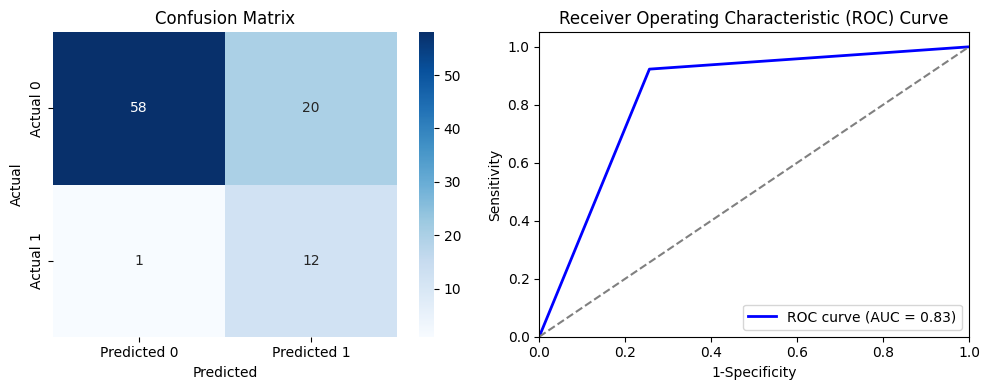

In [17]:
dt_model = DecisionTreeClassifier(random_state=42,
                                  max_depth=15,
                                  min_samples_split=10,
                                  min_samples_leaf=3,
                                  max_features=15,
                                  criterion='entropy')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
cm = plot_roc_curve_and_confusion_matrix(y_test, y_pred_dt)

In [18]:
calculate_metrics_from_confusion_matrix(cm)

,Metric,Score
0,Accuracy,0.769231
1,Precision,0.375000
2,Recall,0.923077
3,F1-score,0.533333


In [19]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['True Label'] = y_test
X_test_with_predictions['Predicted Label'] = y_pred_dt

misclassified = X_test_with_predictions[X_test_with_predictions['True Label'] != X_test_with_predictions['Predicted Label']]
print("Misclassified Observations:")
misclassified[features+['True Label', 'Predicted Label']]

Misclassified Observations:


,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,True Label,Predicted Label
660,26.432462,48.265941,1030.134331,157.834470,120.348485,267.963194,290.599306,6.334912,0.0,1.0
661,20.845423,39.523472,1056.304356,106.375316,104.562500,269.699179,289.832386,5.996212,0.0,1.0
662,9.514236,17.450694,1132.154577,107.142361,79.562500,249.859848,257.658775,3.142361,0.0,1.0
663,22.358793,41.355573,1045.749339,199.908197,92.209906,248.896225,266.942021,4.786321,0.0,1.0
664,29.599306,56.220937,1025.014236,201.729167,98.798611,254.579861,278.947917,5.871528,0.0,1.0
665,29.460448,56.450761,1011.777525,239.528725,96.917298,254.536616,279.101010,6.006629,0.0,1.0
666,29.606218,56.543993,997.720644,222.520202,98.540404,254.928977,279.212121,6.132891,0.0,1.0
667,29.592614,56.686765,993.112247,224.597854,105.084596,253.711174,278.283775,6.343434,0.0,1.0
668,29.468308,56.475530,990.107860,213.606376,105.134785,254.968434,279.388573,6.276831,0.0,1.0
669,29.371023,56.148318,987.010574,194.591225,99.017677,255.260732,279.684028,6.300505,0.0,1.0


In [20]:
test_df[features+['Label']].iloc[-15:]

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,1.0
700,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,1.0
701,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,1.0
702,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,1.0
703,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,1.0
704,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


In [21]:
daily_df[daily_df.NodeID == 7][-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,0.0
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,0.0
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,0.0
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,0.0
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,0.0
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


# $$\textbf{Random Forest}$$
---

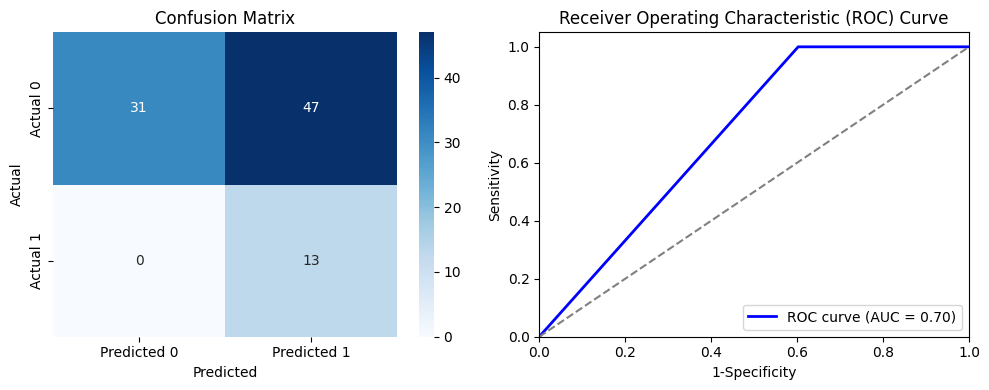

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, 
                                  random_state=1, 
                                  min_samples_split=10, 
                                  min_samples_leaf=5,
                                  max_depth = 10,
                                  criterion='entropy',
                                )
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm3 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf)

In [23]:
calculate_metrics_from_confusion_matrix(cm3)

,Metric,Score
0,Accuracy,0.483516
1,Precision,0.216667
2,Recall,1.000000
3,F1-score,0.356164


In [24]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['True Label'] = y_test
X_test_with_predictions['Predicted Label'] = y_pred_rf

misclassified = X_test_with_predictions[X_test_with_predictions['True Label'] != X_test_with_predictions['Predicted Label']]
print("Misclassified Observations:")
misclassified[features+['True Label', 'Predicted Label']]

Misclassified Observations:


,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,True Label,Predicted Label
621,27.460985,49.235546,1027.834028,171.824495,94.280934,274.809975,297.073232,6.478220,0.0,1.0
622,27.662186,48.846914,1032.661016,178.826697,95.848612,273.275510,294.803808,6.658738,0.0,1.0
623,27.893024,50.361676,1032.041824,179.052715,96.364899,271.142992,293.734217,6.327967,0.0,1.0
624,27.530078,49.629073,1026.985337,164.711718,97.755648,272.472140,294.591144,6.282210,0.0,1.0
625,27.488321,49.011774,1030.220549,162.982323,96.012626,273.292614,295.799558,6.419508,0.0,1.0
626,27.436269,49.780960,1035.660543,156.055871,98.461490,274.707386,297.303662,6.748737,0.0,1.0
627,27.879766,50.120773,1037.238037,176.527146,98.942866,271.773359,294.332386,6.455492,0.0,1.0
628,27.599527,50.046392,1035.025852,161.817235,96.432765,275.028725,297.810922,6.770518,0.0,1.0
629,27.529230,48.831379,1046.422538,168.293876,96.443182,273.087753,295.669192,6.314078,0.0,1.0
630,27.632797,49.741815,1044.488352,167.056503,97.167929,273.498106,296.337121,6.551452,0.0,1.0


In [25]:
test_df[features+['Label']].iloc[-15:]

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,1.0
700,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,1.0
701,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,1.0
702,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,1.0
703,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,1.0
704,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


In [26]:
daily_df[daily_df.NodeID == 7][-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,0.0
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,0.0
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,0.0
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,0.0
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,0.0
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


### Tuning 

[I 2024-06-25 12:48:08,027] A new study created in memory with name: no-name-758b5db9-e4e7-473d-94ac-b705ef7a8e17
[I 2024-06-25 12:48:27,663] Trial 0 finished with value: 0.30952380952380953 and parameters: {'n_estimators': 154, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 162, 'criterion': 'gini', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.30952380952380953.
[I 2024-06-25 12:48:31,606] Trial 1 finished with value: 0.25 and parameters: {'n_estimators': 81, 'max_depth': 32, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 168, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.30952380952380953.
[I 2024-06-25 12:48:34,939] Trial 2 finished with value: 0.3291139240506329 and parameters: {'n_estimators': 108, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 55, 'criterion': 'entropy', 'bootstrap': True, 'class_weight': None}. Best

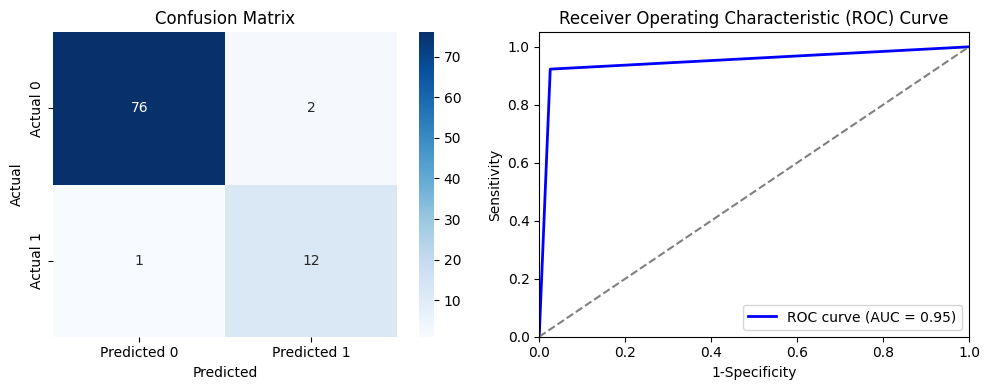

Best F1 Score: 0.8888888888888888
Best Parameters: {'n_estimators': 82, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 208, 'criterion': 'entropy', 'bootstrap': False, 'class_weight': 'balanced'}


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.datasets import make_classification
import optuna

def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_int('max_features', 1, X_train.shape[1]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    rf_model = RandomForestClassifier(**param_dist, random_state=1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_f1 = study.best_value

best_rf_model = RandomForestClassifier(**best_params, random_state=1)
best_rf_model.fit(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)


cm3 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf)
calculate_metrics_from_confusion_matrix(cm3)

print("Best F1 Score:", best_f1)
print("Best Parameters:", best_params)

In [33]:
best_rf_model = RandomForestClassifier(**best_params, random_state=1)
best_rf_model.fit(X_train, y_train)

y_pred_rf3 = best_rf_model.predict(X_test)

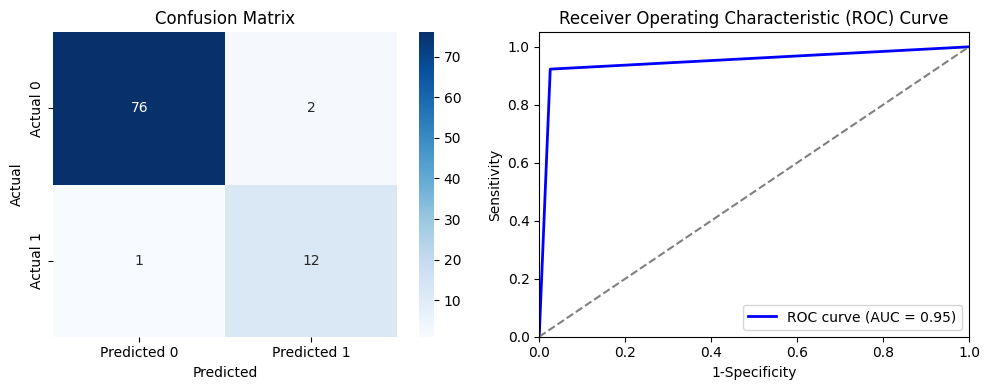

In [34]:
cm3 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf3)

In [35]:
calculate_metrics_from_confusion_matrix(cm3)

,Metric,Score
0,Accuracy,0.967033
1,Precision,0.857143
2,Recall,0.923077
3,F1-score,0.888889


# $${Stop Here}$$
-------------------

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 10), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    dt_model = DecisionTreeClassifier(random_state=15,
                                      max_depth=5,
                                      min_samples_split=6,
                                      min_samples_leaf=3,
                                      max_features=15,
                                      criterion='entropy')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 1), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 2), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 10), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

# $$\textbf{C. Analyisis at Well Level}$$ 

---

## $\textbf{1. Xgboost}$

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    print(f"\n---------NodeID {i}-----------------------------------")
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    
    print("Average Accuracy:", round(accuracy, 3))
    print("Average F1 Score:", round(f1, 3))
    print("Average Recall:", round(recall, 3))

### $$\textbf{Visualizing Most Important Features of Xgboost}$$ 

In [ ]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)
features = merged_df.drop(columns=['Date', 'NodeID', 'Label']).columns
feature_importance = pd.DataFrame(index=features)

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    
    feature_importance[f'NodeID_{i}'] = model.feature_importances_

# Calculate average feature importance across all NodeIDs
feature_importance['Average'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values(by='Average', ascending=False)
feature_importance.head(5)

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['Average'], y=feature_importance.index, hue=feature_importance.index, legend=False)
plt.title('Average Feature Importance for Xgboost')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.show()